[[-0.7048323892719874], [-0.6977857657566573], [0.9468811119336953]]
[71.68085389387336, -90.61867591303064, 30.256863642677416]
0.2689070701599121


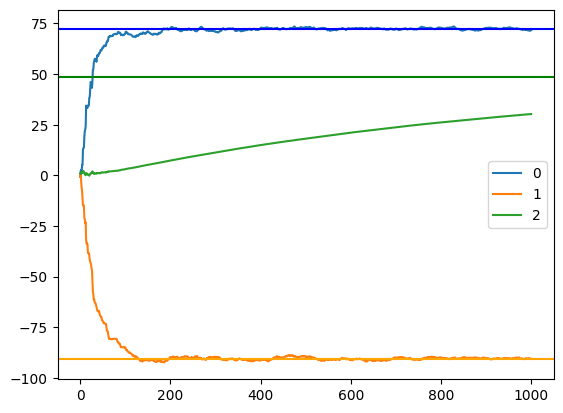

In [6]:
import numpy as np
import matplotlib as plt
from Neuron import *
import time 
import matplotlib.pyplot as plt

class Output_Layer:
    def __init__(self, input_shape, output_shape, activation_func=none):
        neuron_layer = np.array([])
        for x in range(output_shape):
            neuron_layer = np.append(neuron_layer,Perceptron(n_of_weights=input_shape, step=activation_func, activation=activation_func))
        self.neurons = neuron_layer
        
    def get_neuron(self, n):
        return self.neurons[n]
    
    def get_neurons(self):
        return self.neurons
    
    def set_neurons(self, adj_neurons):
        self.neurons = adj_neurons
    
    def forward_pass(self, X):
        output = np.array([])
        for neuron in self.neurons:
            output = np.append(output,neuron.step_pass(X))
        return output
    
    def relu(self, input):
        if input>0:
            return input
        else:
            return 0
        
    def drelu(self, input):
        if input>0:
            return 1
        else:
            return 0

    def sigmoid(self, input):
        return 1/(1+np.e**(-input))

    def dsigmoid(self, input):
        return self.sigmoid(input)*(1-self.sigmoid(input))
    
    def dactivation(self, neuron, input):
        activation = neuron.get_activation()
        if activation=='sigmoid':
            return dsigmoid(neuron.raw_pass(input))
        elif activation=='relu':
            return drelu(neuron.raw_pass(input))
        else:
            return 1
    
    def fit(self, X, y, learning_rate):
        weight_change = [[w] for w in self.get_neurons()[0].get_weights()]
        print(weight_change)
        error = [0]
        neurons = self.get_neurons()
        for k in range(len(X)):
            for n in neurons:
                weights = n.get_weights()[:-1]
                adj_weights = [weights[x]-(learning_rate*(self.forward_pass(X[k])-y[k])*self.dactivation(n,X[k])*X[k][x])[0] for x in range(len(weights))]
                adj_weights.append(n.get_weights()[-1:][0]-(learning_rate*(self.forward_pass(X[k])-y[k])*self.dactivation(n,X[k]))[0])
                n.change_weights(adj_weights)
                for x in range(len(adj_weights)):
                    weight_change[x].append(adj_weights[x])
            error.append(y[k]-n.step_pass(X[k]))
            self.set_neurons(neurons)
        return weight_change, error
    
    
## testing

start = time.time()

layer = Output_Layer(2, 1)

a = np.random.uniform(-100,100)
b = np.random.uniform(-100,100)
c = np.random.uniform(-100,100)

X = np.array([np.random.uniform(-10,10,2) for x in range(1000)])
y = [a*x[0]+b*x[1]+c for x in X]

change, err = layer.fit(X,y, learning_rate=0.001)

print(layer.get_neurons()[0].get_weights())

end = time.time()
print(end-start)

plt.plot(change[0],label='0')
plt.axhline(y=a, color='blue')
plt.plot(change[1],label='1')
plt.axhline(y=b, color='orange')
plt.plot(change[2],label='2')
plt.axhline(y=c, color='green')
plt.legend()
plt.show()

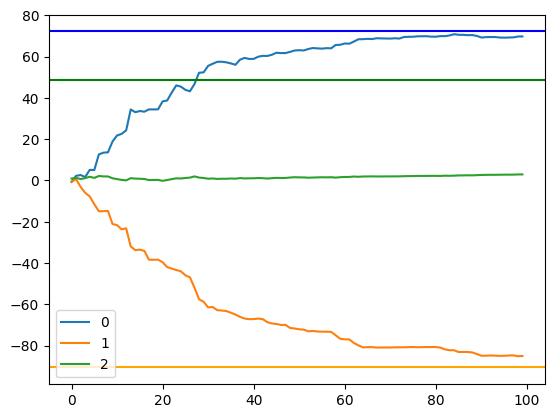

In [7]:
a1 = 0
a2 = 100
plt.plot(change[0][a1:a2],label='0')
plt.axhline(y=a, color='blue')
plt.plot(change[1][a1:a2],label='1')
plt.axhline(y=b, color='orange')
plt.plot(change[2][a1:a2],label='2')
plt.axhline(y=c, color='green')
plt.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib as plt
from Dense_Layer import *
from Output_Layer import *
from Neuron import *

class Model:
    def __init__(self, Layers):
        self.Layers = Layers
        
    def get_Layers(self):
        return self.Layers
    
    def set_Layer(self, new_layer, layer_index):
        self.Layers[layer_index] = new_layer
    
    def forward_pass(self, X):
        output = X
        for layer in self.get_Layers():
            output = layer.forward_pass(output)
        return output
    
    def layer_output(self, X, layer_num):
        output = X
        for layer in self.get_Layers()[:layer_num]:
            output = layer.forward_pass(output)
        return output
    
    def dactivation(self, neuron, input):
        activation = neuron.get_activation()
        if activation=='sigmoid':
            return dsigmoid(neuron.raw_pass(input))
        elif activation=='relu':
            return drelu(neuron.raw_pass(input))
        else:
            return 1
    
    def fit(self, X, y, learning_rate):
        error = []
        for x in range(len(X)):
            # 2d array of gradients for each layer
            layer_change_weights = []
            # derivatives of the last layer
            output_layer = self.get_Layers()[-1:][0]
            output_neurons = output_layer.get_neurons()
            prev_layer = self.get_Layers()[len(self.get_Layers())-2]
            for n in output_neurons:
                weights = n.get_weights()[:-1]
                prev_output = self.layer_output(X[x], len(self.get_Layers())-1)
                adj_weights = [weights[i]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x])*prev_output[i])[0] for i in range(len(weights))]
                adj_weights.append(n.get_weights()[-1:][0]-(learning_rate*(self.forward_pass(X[x])-y[x])*output_layer.dactivation(n,X[x]))[0])
                n.change_weights(adj_weights)
                layer_change_weights.append(adj_weights)
            output_layer.set_neurons(output_neurons)
            self.set_Layer(output_layer, len(self.get_Layers())-1)
            layers = self.get_Layers()
            for k in range(len(layers)-2):
                layer = layers[len(layers)-2-k]
                new_layer_change_weights = []
                neurons = layers[len(layers)-2-k].get_neurons()
                prev_neurons = layers[len(layers)-1-k].get_neurons()
                prev_output = self.layer_output(X[k], len(layers)-2-k)
                for j in range(len(neurons)):
                    weights = neurons[j].get_weights()[:-1]
                    d = 0
                    for l in range(len(prev_neurons)):
                        d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                    d *= layers[k].dactivation(neurons[j], prev_output)
                    adj_weights = [weights[i] - (learning_rate*d*prev_output[i]) for i in range(len(weights))]
                    adj_weights.append(weights[-1:][0]-(learning_rate*d))
                    neurons[j].change_weights(adj_weights)
                    new_layer_change_weights.append(adj_weights)
                layers[len(layers)-2-k].set_neurons(neurons)
                self.set_Layer(layers[len(layers)-2-k], len(layers)-2-k)
                layer_change_weights = new_layer_change_weights
            input_layer = layers[0]
            neurons = input_layer.get_neurons()
            prev_neurons = layers[1].get_neurons()
            for j in range(len(neurons)):
                weights = neurons[j].get_weights()[:-1]
                d = 0
                for l in range(len(prev_neurons)):
                    prev_weights = prev_neurons[l].get_weights()[:-1]
                    d += prev_neurons[l].get_weights()[:-1][j]*layer_change_weights[l][j]
                d *= input_layer.dactivation(neurons[j], X[x])
                adj_weights = [weights[i] - (learning_rate*d*X[x][i]) for i in range(len(weights))]
                adj_weights.append(weights[-1:][0]-(learning_rate*d))
                neurons[j].change_weights(adj_weights)
            input_layer.set_neurons(neurons)
            self.set_Layer(input_layer, 0)
            error.append((self.forward_pass(X[x])[0]-y[x])**2)
        return error

Epoch 1/10, Average MSE: 0.051459710285370955
Epoch 2/10, Average MSE: 0.01177031552639919
Epoch 3/10, Average MSE: 0.009892327500683308
Epoch 4/10, Average MSE: 0.009118741777169398
Epoch 5/10, Average MSE: 0.008628705590227846
Epoch 6/10, Average MSE: 0.007862762276332168
Epoch 7/10, Average MSE: 0.007087198407588977
Epoch 8/10, Average MSE: 0.00644267586457041
Epoch 9/10, Average MSE: 0.005627132831082449
Epoch 10/10, Average MSE: 0.004823872088222624


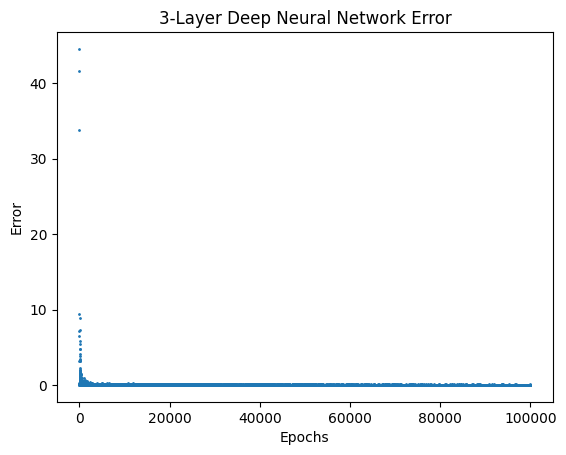

In [5]:
import numpy as np
import matplotlib as plt
from Dense_Layer import *
from Output_Layer import *
from Neuron import *
from Model import *

model = Model(Layers=[
    Dense_Layer(input_shape=1,output_shape=5, activation_func="relu"),
    Dense_Layer(input_shape=5,output_shape=5, activation_func="relu"),
    Output_Layer(input_shape=5,output_shape=1)
])

X = np.random.uniform(-1, 1, size=(10000, 1))
y = 2 * X**2 + 3 * X + 4

error = model.fit(X, y, learning_rate=0.05, epochs=10)
plt.scatter(range(len(error)), error, s=1)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

In [ ]:
error2 = model.fit(X, y, learning_rate=0.05, epochs=10)
moving_average = np.convolve(error2, np.ones(5000)/5000, mode='valid')
plt.plot(moving_average)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

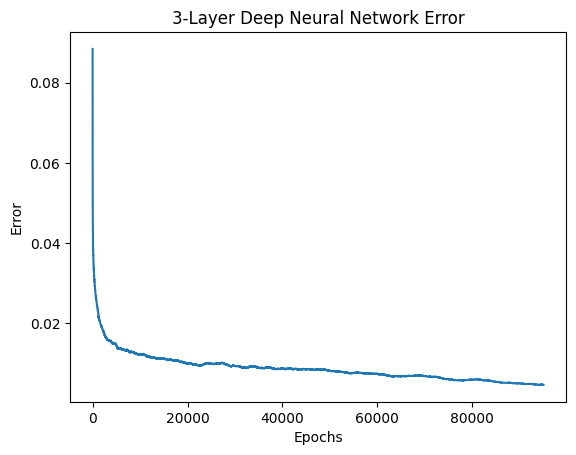

In [6]:
# X = np.random.uniform(-1, 1, size=(20000, 1))
# y = [2*X[x][0]+-2*X[x][1]-1 for x in range(len(X))]
# a = model.fit(X,y,learning_rate=0.0001)
# error = error + [a[x][0] for x in range(len(a))]
moving_average = np.convolve(error, np.ones(5000)/5000, mode='valid')
plt.plot(moving_average)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("{layers}-Layer Deep Neural Network Error".format(layers=len(model.get_Layers())))
plt.show()

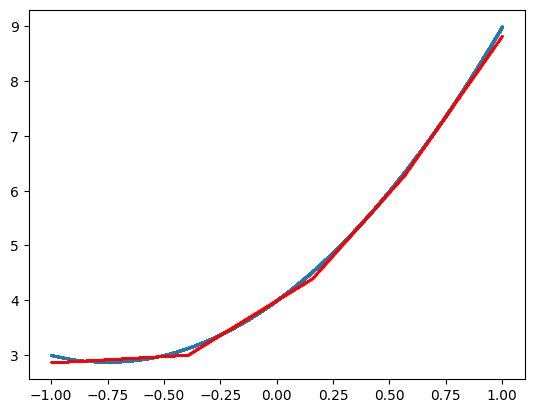

In [7]:
# plot the models graph
# model_t = Model(Layers=[
#     Dense_Layer(input_shape=1,output_shape=3, activation_func="relu"),
#     Dense_Layer(input_shape=3,output_shape=3, activation_func="relu"),
#     Output_Layer(input_shape=3,output_shape=1)
# ])
# X = np.random.uniform(-1, 1, size=(1000, 1))
# y = [2*X[x] for x in range(len(X))]
plt.scatter(X,y, s=1)
plt.scatter(X,[model.forward_pass(x)[0] for x in X], color='red', s=0.1)
plt.show()

Epoch 1/10
10000/10000 [==============================] - 46s 5ms/step - loss: 0.0034
Epoch 2/10
10000/10000 [==============================] - 51s 5ms/step - loss: 1.6546e-06
Epoch 3/10
10000/10000 [==============================] - 40s 4ms/step - loss: 3.3669e-07
Epoch 4/10
10000/10000 [==============================] - 44s 4ms/step - loss: 1.3014e-07
Epoch 5/10
10000/10000 [==============================] - 37s 4ms/step - loss: 6.6353e-08
Epoch 6/10
10000/10000 [==============================] - 52s 5ms/step - loss: 4.3516e-08
Epoch 7/10
10000/10000 [==============================] - 41s 4ms/step - loss: 3.2976e-08
Epoch 8/10
10000/10000 [==============================] - 43s 4ms/step - loss: 2.8417e-08
Epoch 9/10
10000/10000 [==============================] - 42s 4ms/step - loss: 2.2862e-08
Epoch 10/10
10000/10000 [==============================] - 45s 4ms/step - loss: 1.6654e-08


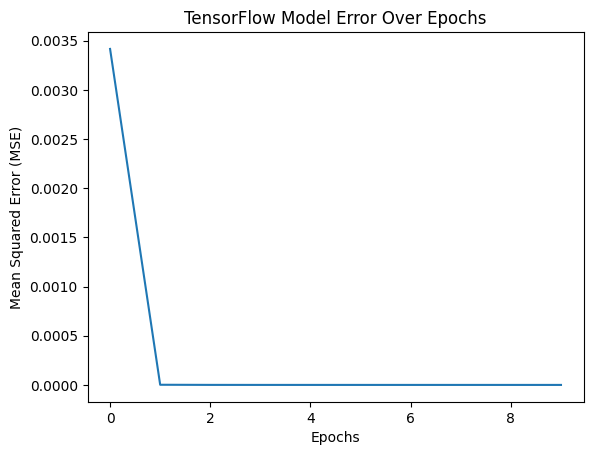

313/313 [==============================] - 2s 5ms/step


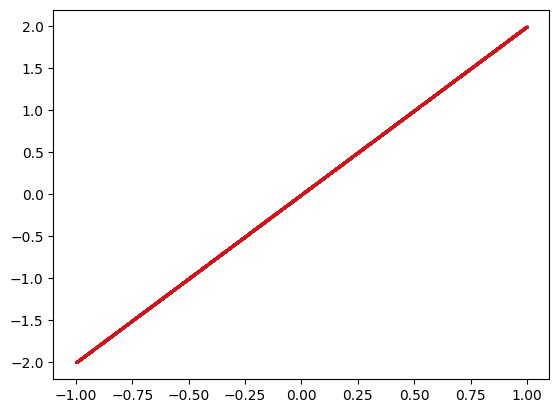

In [15]:
import tensorflow as tf

# Define the model architecture (same as your custom implementation)
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=5, input_shape=(1,), activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

# Compile the model (similar to your custom implementation with MSE and SGD)
tf_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=0.05))

# Custom callback to store loss per epoch, similar to your custom 'error' list
class CustomHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        error_history.append(logs['loss'])  # Save the loss (MSE) at the end of each epoch

# Prepare data (similar to your custom implementation)
X = np.random.uniform(-1, 1, size=(10000, 1))
y = 2 * X

# List to track error (like in your custom implementation)
error_history = []

# Train the model with full-batch gradient descent (batch_size=len(X))
tf_model.fit(X, y, epochs=10, batch_size=1, callbacks=[CustomHistory()])

# Plot the error over epochs (similar to your custom plot)
plt.plot(range(len(error_history)), error_history)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("TensorFlow Model Error Over Epochs")
plt.show()
plt.scatter(X,y, s=1)
plt.scatter(X,tf_model.predict(X), color='red', s=0.1)
plt.show()

In [16]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Normalize the feature data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(120, 4)

In [18]:
model = Model(Layers=[
    Dense_Layer(input_shape=4,output_shape=5, activation_func="relu"),
    Dense_Layer(input_shape=5,output_shape=5, activation_func="relu"),
    Dense_Layer(input_shape=5,output_shape=5, activation_func="relu"),
    Output_Layer(input_shape=5,output_shape=3, activation_func="sigmoid")
])

model.summary()


Dense Layer  | 5 neurons | 4 weights | 1 bias
Dense Layer  | 5 neurons | 5 weights | 1 bias
Dense Layer  | 5 neurons | 5 weights | 1 bias
Output Layer | 3 outputs | 5 weights | 1 bias
Input Shape: 4
Output Shape: 3


In [20]:
learning_rate = 0.01
epochs = 1000

# Train the model
errors = model.fit(X_train, y_train, learning_rate=learning_rate, epochs=epochs)

# Predict on the test set
predictions = []
for x in X_test:
    output = model.forward_pass(x)
    predictions.append(np.argmax(output))  # Convert output to predicted class

# Get the true labels for the test set
actual = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(np.array(predictions) == actual)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/1000, Average MSE: 0.15274934656206648
Epoch 2/1000, Average MSE: 0.14771790716889738
Epoch 3/1000, Average MSE: 0.14313277084570455
Epoch 4/1000, Average MSE: 0.13892268874624675
Epoch 5/1000, Average MSE: 0.13503501083665836
Epoch 6/1000, Average MSE: 0.13150854958814528
Epoch 7/1000, Average MSE: 0.12816182178965546
Epoch 8/1000, Average MSE: 0.12518140291741453
Epoch 9/1000, Average MSE: 0.12217346560936788
Epoch 10/1000, Average MSE: 0.11941970985980352
Epoch 11/1000, Average MSE: 0.11681604628887378
Epoch 12/1000, Average MSE: 0.11440029270568086
Epoch 13/1000, Average MSE: 0.11207405016378989
Epoch 14/1000, Average MSE: 0.10973980109266693
Epoch 15/1000, Average MSE: 0.10767865790405144
Epoch 16/1000, Average MSE: 0.10537090489892907
Epoch 17/1000, Average MSE: 0.10337577716624517
Epoch 18/1000, Average MSE: 0.10138351823729005
Epoch 19/1000, Average MSE: 0.09964973442676044
Epoch 20/1000, Average MSE: 0.09772171314777015
Epoch 21/1000, Average MSE: 0.09584626064566786
E

In [25]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the 28x28 images into 1D vectors of size 784
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [26]:
model = Model(Layers=[
    Dense_Layer(input_shape=784,output_shape=64, activation_func="relu"),
    Dense_Layer(input_shape=64,output_shape=12, activation_func="relu"),
    Output_Layer(input_shape=12,output_shape=10, activation_func="sigmoid")
])

model.summary()

Dense Layer  | 64 neurons | 784 weights | 1 bias
Dense Layer  | 12 neurons | 64 weights | 1 bias
Output Layer | 10 outputs | 12 weights | 1 bias
Input Shape: 784
Output Shape: 10


In [27]:
learning_rate = 0.01
epochs = 1000  # You might want to start with fewer epochs for MNIST

# Train the model on the training set
errors = model.fit(X_train, y_train, learning_rate=learning_rate, epochs=epochs)

KeyboardInterrupt: 